<a href="https://colab.research.google.com/github/hindia-vic/deep_learning/blob/main/Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf


In [2]:
#import handwritten dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

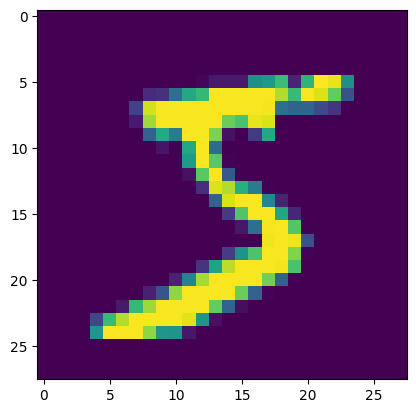

In [5]:
plt.imshow(x_train[0])

In [6]:
X_train=x_train/255
X_test=x_test/255

In [7]:
from tensorflow.keras import models,layers

In [8]:
ann=models.Sequential([
    layers.Flatten(input_shape=(28,28)),
    layers.Dense(3000,activation='relu'),
    layers.Dense(1000,activation='relu'),
    layers.Dense(10,activation='sigmoid')
])

In [9]:
ann.compile(optimizer='SGD',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [10]:
ann.fit(X_train,y_train,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 93s 49ms/step - loss: 0.4972 - accuracy: 0.8803
Epoch 2/5
1875/1875 [==============================] - 84s 45ms/step - loss: 0.2502 - accuracy: 0.9295
Epoch 3/5
1875/1875 [==============================] - 85s 45ms/step - loss: 0.2009 - accuracy: 0.9437
Epoch 4/5
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1683 - accuracy: 0.9527
Epoch 5/5
1875/1875 [==============================] - 83s 44ms/step - loss: 0.1442 - accuracy: 0.9594


In [11]:
ann.evaluate(X_test,y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.1381 - accuracy: 0.9593


[0.1380591243505478, 0.9592999815940857]

In [12]:
 prediction=ann.predict(X_test).argmax(axis=1)

313/313 [==============================] - 5s 14ms/step


In [13]:
prediction[:5]

array([7, 2, 1, 0, 4])

In [14]:
y_test[:5]

array([7, 2, 1, 0, 4], dtype=uint8)

In [15]:
#saving the model to my local pc
ann.save('ann.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from google.colab import files
files.download('ann.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Quantization  in  deep learning model
Quantization is the process of  reducing  model sizes so that it can run on edge devices

In [17]:
#converting  using post training quantization
convert=tf.lite.TFLiteConverter.from_keras_model(ann)
tflite_model=convert.convert()

In [ ]:
conver=tf.lite.TFLiteConverter.from_keras_model(ann)
conver.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_quant_model=conver.convert()

In [19]:
with open ('tflite_model.tflite','wb') as f:
  f.write(tflite_model)
with open ('tflite_quant_model.tflite','wb') as f:
  f.write(tflite_quant_model)

In [20]:
from google.colab import files

# Download the first model
files.download('tflite_model.tflite')

# Download the second model
files.download('tflite_quant_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2.Quantization aware training


In [21]:
!pip install tensorflow==2.13.0
!pip install -q tensorflow-model-optimization

In [22]:
import tensorflow_model_optimization as tfmot
from tensorflow import keras
import os

# Define the model using the Functional API
def create_functional_model():
    inputs = keras.Input(shape=(28, 28))
    x = keras.layers.Flatten()(inputs)
    x = keras.layers.Dense(3000, activation='relu')(x)
    x = keras.layers.Dense(1000, activation='relu')(x)
    outputs = keras.layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the functional model
model = create_functional_model()

# Quantize the model
quantize_model = tfmot.quantization.keras.quantize_model
quantize_aware = quantize_model(model)

# Compile and summarize
quantize_aware.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
quantize_aware.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_flatten_1 (QuantizeW  (None, 784)               1         
 rapperV2)                                                       
                                                                 
 quant_dense_3 (QuantizeWra  (None, 3000)              2355005   
 pperV2)                                                         
                                                                 
 quant_dense_4 (QuantizeWra  (None, 1000)              3001005   
 pperV2)                                                     

In [23]:
quantize_aware.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 129s 68ms/step - loss: 0.5020 - accuracy: 0.8777


In [25]:
quantize_aware.evaluate(X_test,y_test)

313/313 [==============================] - 9s 27ms/step - loss: 0.2671 - accuracy: 0.9254


[0.26714184880256653, 0.9254000186920166]

In [29]:
converter=tf.lite.TFLiteConverter.from_keras_model(quantize_aware)
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_quant_model=converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [30]:
with open ('tflite_quant_model.tflite','wb') as f:
  f.write(tflite_quant_model)